In [1]:
import numpy as np
import pyhdf
from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *
from datetime import datetime, timezone
from scipy import interpolate
import glob
import os
import matplotlib.pyplot as plt
import netCDF4 as nc
from geopy.distance import geodesic

In [2]:
## ===============================================
def read_2b_cldclass_lidar(cs_file,latbin=None):
## ===============================================
  f_2b_cldclass_lidar=SD(cs_file, SDC.READ)
  sds_obj=f_2b_cldclass_lidar.select('CloudLayerBase')
  cs_clb =sds_obj.get()
  sds_obj=f_2b_cldclass_lidar.select('CloudLayerTop')
  cs_clt =sds_obj.get()

  ## geolocation fields
  sdc_2bcldclass_lidar=HDF(cs_file, SDC.READ)
  vs_2bcldclass_lidar=sdc_2bcldclass_lidar.vstart()
  cs_QC = np.squeeze(vs_2bcldclass_lidar.attach('Data_quality')[:])
  Latitude = np.squeeze(vs_2bcldclass_lidar.attach('Latitude')[:])
  Longitude = np.squeeze(vs_2bcldclass_lidar.attach('Longitude')[:])

  ilat = np.squeeze(np.argwhere((Latitude >= latbin[0]) & (Latitude <= latbin[1])))
  cs_clb = cs_clb[ilat,:]
  cs_clt = cs_clt[ilat,:]
  cs_QC = cs_QC[ilat]
  Latitude = Latitude[ilat]
  Longitude = Longitude[ilat]

  return(cs_clb,cs_clt,cs_QC,Latitude,Longitude)

## ===============================================
def read_cs_ecmwf(aux_file,latbin=None):
## ===============================================
  f_ecmwf=SD(aux_file, SDC.READ)
  sds_obj=f_ecmwf.select('Pressure')
  Pressure =sds_obj.get()
  sds_obj=f_ecmwf.select('Temperature')
  Temperature =sds_obj.get()
  sds_obj=f_ecmwf.select('Specific_humidity')
  Specific_humidity =sds_obj.get()
  #sds_obj=f_ecmwf.select('U_velocity')
  #U_velocity =sds_obj.get()
  #sds_obj=f_ecmwf.select('V_velocity')
  #V_velocity =sds_obj.get()

  ## geolocation fields
  sdc_ecmwf=HDF(aux_file, SDC.READ)
  vs_ecmwf=sdc_ecmwf.vstart()
  EC_height = np.squeeze(vs_ecmwf.attach('EC_height')[:])
  Profile_time = np.squeeze(vs_ecmwf.attach('Profile_time')[:])
  UTC_start = np.squeeze(vs_ecmwf.attach('UTC_start')[:])
  #TAI_start = np.squeeze(vs_ecmwf.attach('TAI_start')[:])
  Latitude = np.squeeze(vs_ecmwf.attach('Latitude')[:])
  Longitude = np.squeeze(vs_ecmwf.attach('Longitude')[:])
  DEM_elevation = np.squeeze(vs_ecmwf.attach('DEM_elevation')[:])
  Skin_temperature = np.squeeze(vs_ecmwf.attach('Skin_temperature')[:])
  Surface_pressure = np.squeeze(vs_ecmwf.attach('Surface_pressure')[:])
  Temperature_2m = np.squeeze(vs_ecmwf.attach('Temperature_2m')[:])
  #Sea_surface_temperature = np.squeeze(vs_ecmwf.attach('Sea_surface_temperature')[:])
  U10_velocity = np.squeeze(vs_ecmwf.attach('U10_velocity')[:])
  V10_velocity = np.squeeze(vs_ecmwf.attach('V10_velocity')[:])


  UTC_Time = UTC_start + Profile_time
  UTC_Time = UTC_Time/60./60.
  ilat = np.squeeze(np.argwhere((Latitude >= latbin[0]) & (Latitude <= latbin[1])))
  Pressure = Pressure[ilat,:]
  Temperature = Temperature[ilat,:]
  Specific_humidity = Specific_humidity[ilat,:]
  DEM_elevation = DEM_elevation[ilat]
  Skin_temperature = Skin_temperature[ilat]
  Temperature_2m = Temperature_2m[ilat]
  U10_velocity = U10_velocity[ilat]
  V10_velocity = V10_velocity[ilat]
  UTC_Time = UTC_Time[ilat]


  return(Pressure,DEM_elevation,Temperature,Specific_humidity,EC_height,Temperature_2m,U10_velocity,V10_velocity,UTC_Time)

In [3]:
def find_files(directory, prefix):
    matching_files = []
    for filename in os.listdir(directory):
        if filename.startswith(prefix):
            matching_files.append(os.path.join(directory, filename))
    return matching_files

def gather_files(YYYY, DDD, HH, ROOT):
    ABI_ = {
        "ROOT_PATH": None,

        "YYYY": None,
        "DDD": None,
        "HH": None,

        "00": [],
        # "10": [],
        "15": [],
        # "20": [],
        "30": [],
        # "40": [],
        "45": [],
        # "50": [],

        "L200": None,
        "L210": None,
        "L220": None,
        "L230": None,
        "L240": None,
        "L250": None
    }

    _ABI_PATH_ = ROOT + YYYY + "/" + DDD + "/" + HH

    for filename in os.listdir(_ABI_PATH_):
        if ABI_["ROOT_PATH"] == None:
            ABI_["ROOT_PATH"] = _ABI_PATH_
            ABI_["YYYY"] = filename[27:31]
            ABI_["DDD"] = filename[31:34]
            ABI_["HH"] = filename[34:36]
        MM = filename[36:38]
        ABI_[f"{MM}"].append(filename)

    return ABI_

def get_L1B_L2(abipaths, l2path, YYYY, DDD, HH, ROOT):

    # ASSERT ALL ABI CHANNELS PRESENT !!!!!!!!!!!!!!!!!!!!
    assert len(abipaths) == 16, "NOT ALL ABI FILES LOCATED"
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


    # LOAD EACH ABI CHANNEL IMAGE
    CHANNELS = []
    # ROOT = "/css/geostationary/BackStage/GOES-16-ABI-L1B-FULLD/"

    for file in abipaths:
        L1B = np.array(nc.Dataset(ROOT + "/" + YYYY + "/" + DDD + "/" + HH + "/" + file, 'r')["Rad"])
        CHANNEL = int(file[19:21])
        CHANNELS.append((L1B, CHANNEL))

    # SORT CHANNELS
    CHANNELS.sort(key=lambda x: x[1])
    CHANNELS = [C[0] for C in CHANNELS]

    T = []
    #RESIZE ALL CHANNELS TO SAME SIZE
    for C in CHANNELS:
        S = C.shape[0] // 5424
        if S == 1:
            C = np.repeat(C, 2, axis=0)
            C = np.repeat(C, 2, axis=1)
        if S == 4:
            C = C[::2, ::2]
        T.append(C)

    CHANNELS = T

    # STACK ABI CHANNELS INTO SINGLE IMAGE
    ABI = np.stack(CHANNELS, axis=2)

    return ABI

In [11]:
BOUND_SIZE = 2000
LENGTH = 10848

In [36]:
# READ IN ABI_EAST in order to find the latitude and longitude of each file
f = nc.Dataset("../ABI_EAST_GEO_TOPO_LOMSK.nc")
abiLong = np.array(f['Longitude'])
abiLat = np.array(f['Latitude'])

# Get the latitude and longitude boundaries within the bounded region

abiLongB = abiLong[BOUND_SIZE:LENGTH-BOUND_SIZE, BOUND_SIZE:LENGTH-BOUND_SIZE]
abiLatB = abiLat[BOUND_SIZE:LENGTH-BOUND_SIZE, BOUND_SIZE:LENGTH-BOUND_SIZE]
abiLongB[abiLongB == -999] = 10
abiLatB[abiLatB == -999] = 10
longMin = abiLongB.min()
longMax = abiLongB.max()
latMin = abiLatB.min()
latMax = abiLatB.max()
print(longMin, longMax, latMin, latMax)

6.1570315
-120.95703 -29.042973 -35.768463 35.76846


Text(0.5, 1.0, 'Latitude')

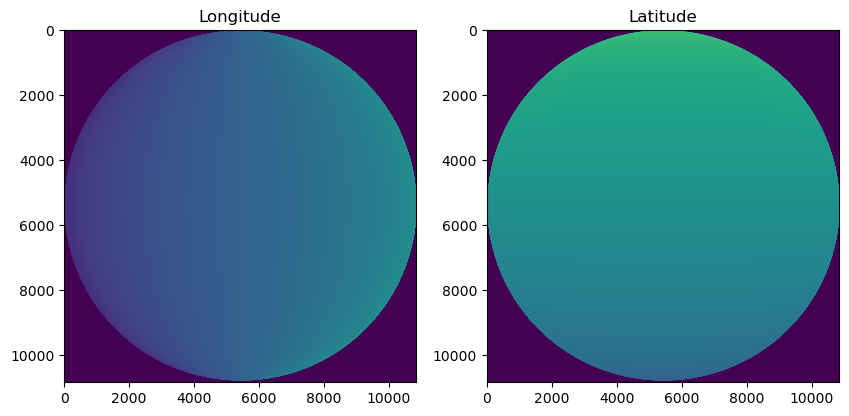

In [17]:
# Double check if they loaded correctly
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im0 = axes[0].imshow(abiLong, vmin = -200, vmax = 200)
im1 = axes[1].imshow(abiLat, vmin = -200, vmax = 200)
# axes[0].axis('off')
# axes[1].axis('off')
axes[0].set_title("Longitude")
axes[1].set_title("Latitude")
# plt.colorbar(im0, ax=axes[0])
# plt.colorbar(im1, ax=axes[1])

# TEST FOOTPRINT SIZE
# for i in np.arange(5000,5100):
#   coords_1 = (abiLat[i,5000],abiLong[i,5000])
#   coords_2 = (abiLat[i+1,5000],abiLong[i+1,5000])
 
#   dis = geodesic(coords_1,coords_2).km
#   print(dis)

In [19]:
# Store already parsed files for more efficiency

GATHERED_ABI_FILES = {}
COLLECTED_ABI_DATA = {}

In [90]:
def interpArray(a):
    N = len(a)
    M = len(a[0])
    a_interp = np.zeros((N, 40))

    for i in range(N):
        f = interpolate.interp1d(np.linspace(0,1,M), a[i], kind='linear')
        a_interp[i] = f(np.linspace(0, 1, 40))

    return a_interp

def processTime(t, yy, ddn, lat, lon, ABI_ROOT):
    if np.floor(t) < 19:
        raise ValueError("Times must be between 19-23")

    if lat < latMin or lat > latMax or lon < longMin or lon > longMax:
        raise ValueError("Latitude and Longitude are not correctly bounded")

    hour = np.floor(t).astype(int)
        
    # Find the closest minute
    minutes = np.round((t - np.floor(t)) * 4).astype(int) * 15

    # If minutes is closer to the next hour, shift the hour forward by one, unless that would cause a day shift
    if minutes == 60:
        if hour != 23:
            hour += 1
            minutes = 0
        else:
            minutes = 45

    # Gather the ABI_FILE
    DATA = GATHERED_ABI_FILES.get(f'{yy}-{ddn}-{hour}')
    if DATA is None:
        DATA = gather_files(str(yy), str(ddn), str(hour), ABI_ROOT)
        GATHERED_ABI_FILES[f'{yy}-{ddn}-{hour}'] = DATA

    ABI = COLLECTED_ABI_DATA.get(f'{yy}-{ddn}-{hour}-{minutes}')
    if ABI is None:
        ABI = get_L1B_L2(DATA[str(minutes)], DATA["L200"], DATA["YYYY"], DATA["DDD"], DATA["HH"], ABI_ROOT)
        COLLECTED_ABI_DATA[f'{yy}-{ddn}-{hour}-{minutes}'] = ABI

    # Find the proper index using Manhattan distance
    distances = np.abs(abiLat - lat) + np.abs(abiLong - lon)

    distances = distances[BOUND_SIZE:LENGTH-BOUND_SIZE,BOUND_SIZE:LENGTH-BOUND_SIZE]

    # Find minimum value in distances array
    coords = np.unravel_index(distances.argmin(), distances.shape)
    coords = np.array(coords) + BOUND_SIZE
    # print(coords)
    # print(f'Latitude and Longitude of input: {lat} {lon}')
    # print(coords)
    # print(f'Latitude and Longitude of coords: {abiLat[coords[0], coords[1]]} {abiLong[coords[0], coords[1]]}')

    chip = ABI[coords[0]-64:coords[0]+64, coords[1]-64:coords[1]+64, :]

    return chip, coords
    
def processFile(yy, ddn, orbit):
    cloudsatpath = '/explore/nobackup/people/jgong/cloudsat/'
    #cloudsatpath = '/discover/nobackup/jgong/cloudsat/'
    cs_file = glob.glob(cloudsatpath+'2B-CLDCLASS-LIDAR/'+yy+'/'+ddn+'/'+yy+ddn+'*'+orbit+'*2B-CLDCLASS-LIDAR*'+'P1_R05*.hdf')
    aux_file = glob.glob(cloudsatpath+'ECMWF-AUX/'+yy+'/'+ddn+'/'+yy+ddn+'*'+orbit+'*ECMWF-AUX*'+'P1_R05*.hdf')

    [Pressure,DEM_elevation,Temperature,Specific_humidity,EC_height,Temperature_2m,\
        U10_velocity,V10_velocity,UTC_Time] = read_cs_ecmwf(aux_file[0],latbin=latb)

    ##========== read 2b-cldclass-lidar ================================
    [cs_clb,cs_clt,cs_QC,Latitude,Longitude] = read_2b_cldclass_lidar(cs_file[0],latbin=latb)
    
    Pressure = interpArray(Pressure)
    Temperature = interpArray(Temperature)
    Specific_humidity = interpArray(Specific_humidity)
    
    N = len(cs_clb)

    cs_clb_2 = np.floor(2 * cs_clb).astype(int)
    cs_clt_2 = np.floor(2 * cs_clt).astype(int)
    
    newRescaled = np.zeros((N, 40)).astype(int)
    for i in range(N):
        for j in range(10):
            if cs_clb[i, j] == -99:
                break
            newRescaled[i, cs_clb_2[i, j]:cs_clt_2[i, j]+1] = 1

    # Find corresponding ABI file to the UTC_Time

    i = 0
    
    while i < N:
        try:
            chip, coords = processTime(UTC_Time[i], yy, ddn, Latitude[i], Longitude[i], '/explore/nobackup/people/szhang16/ABI-L1b-RadF/')
        except ValueError:
            i += 1
            continue

        dRange = np.arange(i-64, i+64)
        aux_data = {
            "Pressure": Pressure[dRange],
            "DEM_elevation": DEM_elevation[dRange],
            "Temperature": Temperature[dRange],
            "Specific_humidity": Specific_humidity[dRange],
            "EC_height": EC_height,
            "Temperature_2m": Temperature_2m[dRange],
            "U10_velocity": U10_velocity[dRange],
            "V10_velocity": V10_velocity[dRange],
            "UTC_Time": UTC_Time[dRange],
            "Latitude": Latitude[dRange],
            "Longitude": Longitude[dRange],
            "Cloud_mask": newRescaled[dRange],
        }

        fileName = f'{yy}-{ddn}-{orbit}_{coords[0]}-{coords[1]}'

        np.savez('/explore/nobackup/people/szhang16/abiCloudSATChips/' + fileName, chip=chip, data=aux_data)
        print(fileName)

        i += 90

In [91]:
#=================================
#    MAIN
#=================================
yy = '2019'
ddn = '045'; orbit = '68181'

processFile(yy, ddn, orbit)

# for i in np.arange(10):
#   tmp=np.squeeze(cs_clt[:,i])
#   ind=np.argwhere(tmp>0)
#   print(len(ind),len(tmp))

#---- implementing the 40-level cloud mask processing code from ----
#---- https://colab.research.google.com/drive/1cIsSLS5ht8PXQ8bAbJpboAIxrnanwupu -----

2019-045-68181_8847-2894
2019-045-68181_8847-2877
2019-045-68181_8782-2832
2019-045-68181_8710-2786
2019-045-68181_8637-2740
2019-045-68181_8562-2694
2019-045-68181_8487-2649
2019-045-68181_8411-2605
2019-045-68181_8333-2561
2019-045-68181_8255-2518
2019-045-68181_8176-2475
2019-045-68181_8097-2434
2019-045-68181_8016-2393
2019-045-68181_7934-2352
2019-045-68181_7852-2313
2019-045-68181_7769-2274
2019-045-68181_7685-2236
2019-045-68181_7600-2198
2019-045-68181_7515-2162
2019-045-68181_7430-2126
2019-045-68181_7343-2091
2019-045-68181_7256-2057
2019-045-68181_7168-2024
2019-045-68181_7080-2000
2019-045-68181_6993-2000
2019-045-68181_6904-2000
2019-045-68181_6815-2000
2019-045-68181_6726-2000
2019-045-68181_6636-2000
2019-045-68181_6545-2000
2019-045-68181_6454-2000
2019-045-68181_6363-2000
2019-045-68181_6271-2000
2019-045-68181_6179-2000
2019-045-68181_6086-2000
2019-045-68181_5994-2000
2019-045-68181_5901-2000
2019-045-68181_5807-2000
2019-045-68181_5714-2000
2019-045-68181_5621-2000


{'Pressure': array([[2475.14428711, 2790.71967648, 3170.36199795, ..., -999.        ,
        -999.        , -999.        ],
       [2475.13745117, 2790.70751953, 3170.34792543, ..., -999.        ,
        -999.        , -999.        ],
       [2475.13037109, 2790.69580704, 3170.33425356, ..., -999.        ,
        -999.        , -999.        ],
       ...,
       [2476.52587891, 2790.68113356, 3169.75048828, ..., -999.        ,
        -999.        , -999.        ],
       [2476.55566406, 2790.69644556, 3169.76026643, ..., -999.        ,
        -999.        , -999.        ],
       [2476.58520508, 2790.71220202, 3169.77004457, ..., -999.        ,
        -999.        , -999.        ]]), 'DEM_elevation': array([-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
    

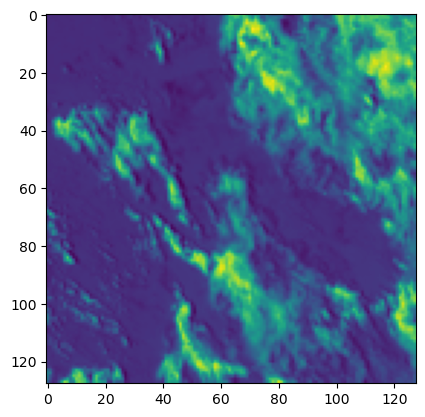

In [97]:
f = np.load("/explore/nobackup/people/szhang16/abiCloudSATChips/2019-045-68181_5994-2000.npz", allow_pickle=True)
plt.imshow(f['chip'][..., 0])
print(f['data'])

In [7]:
N = len(cs_clb)

cs_clb_2 = np.floor(2 * cs_clb).astype(int)
cs_clt_2 = np.floor(2 * cs_clt).astype(int)

newRescaled = np.zeros((N, 40)).astype(int)
for i in range(N):
    for j in range(10):
        if cs_clb[i, j] == -99:
            break
        newRescaled[i, cs_clb_2[i, j]:cs_clt_2[i, j]+1] = 1

# print(cs_clb[6000, :])
# print(cs_clt[6000, :])
# newRescaled[6000, :]

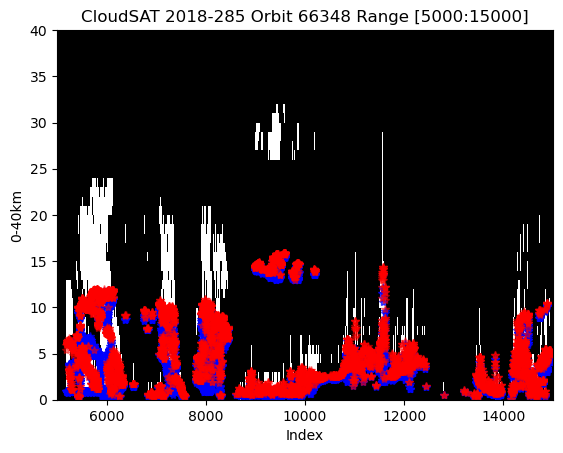

In [89]:
index = np.arange(5000, 15000, 1)
plt.imshow(newRescaled[index].T, cmap='gray', interpolation='nearest', aspect='auto', extent=[5000, 15000, 40, 0])
plt.gca().invert_yaxis()
plt.title('CloudSAT 2018-285 Orbit 66348 Range [5000:15000]')
plt.xlabel('Index')
plt.ylabel('0-40km')
plt.ylim(0,40)
plt.plot(index, cs_clb[index], 'b*', alpha=0.7)
plt.plot(index,cs_clt[index], 'r*', alpha=0.5)
plt.show()

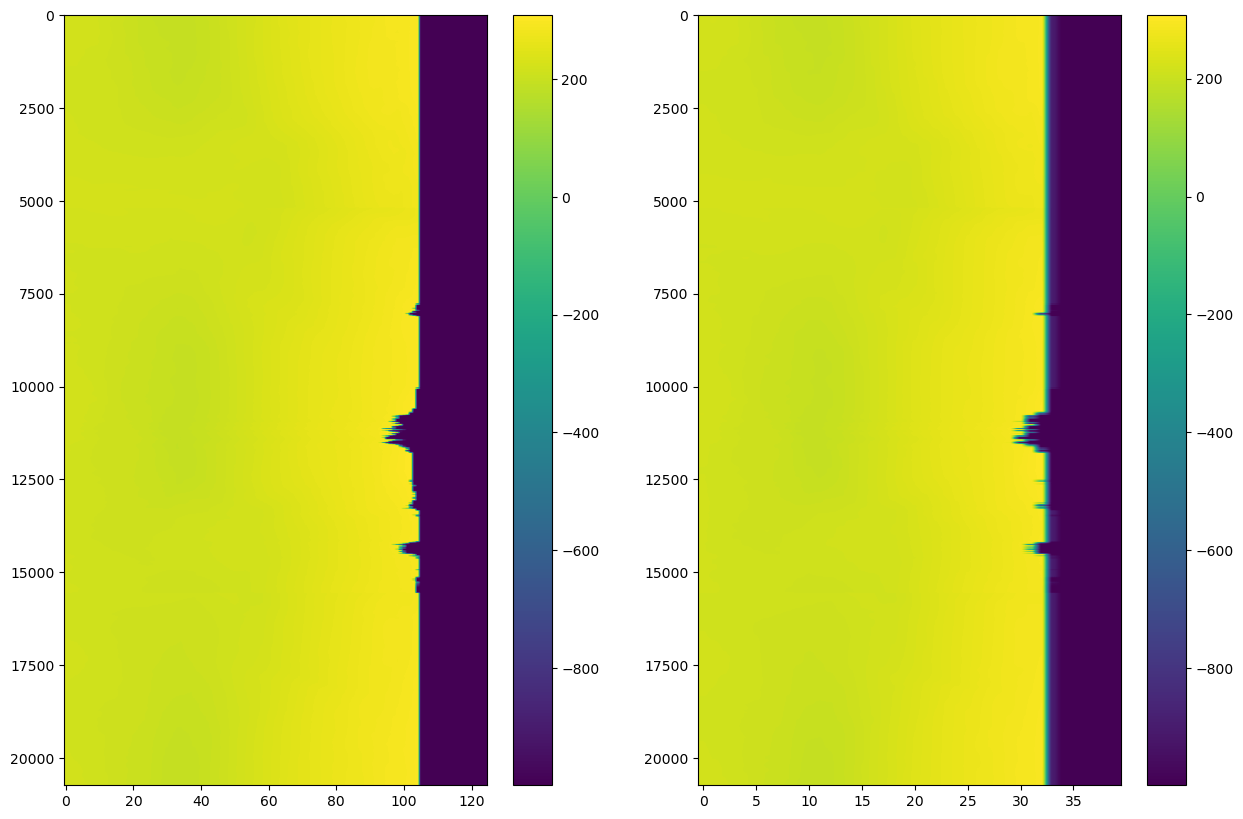

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
# im0 = axes[0].imshow(np.log(Temperature), aspect='auto', vmin=5, vmax=6)
# im1 = axes[1].imshow(np.log(Temperature_interp), aspect='auto', vmin=5, vmax=6)
im0 = axes[0].imshow(Temperature, aspect='auto')
im1 = axes[1].imshow(Temperature_interp, aspect='auto')
plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])